In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

In [ ]:
import math

In [ ]:
# Genero los datos
def make_circle(r, n, noise = 30, seed = 1234):
  np.random.seed(seed)
  return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-noise,noise), math.sin(2*math.pi/n*x)*r+np.random.normal(-noise,noise)) for x in range(1,n+1)]

small_circle = make_circle(100, 300, 10)
medium_circle = make_circle(300, 700, 20)
big_circle = make_circle(500, 1000, 30)

noise = [(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)]

<Axes: xlabel='x', ylabel='y'>

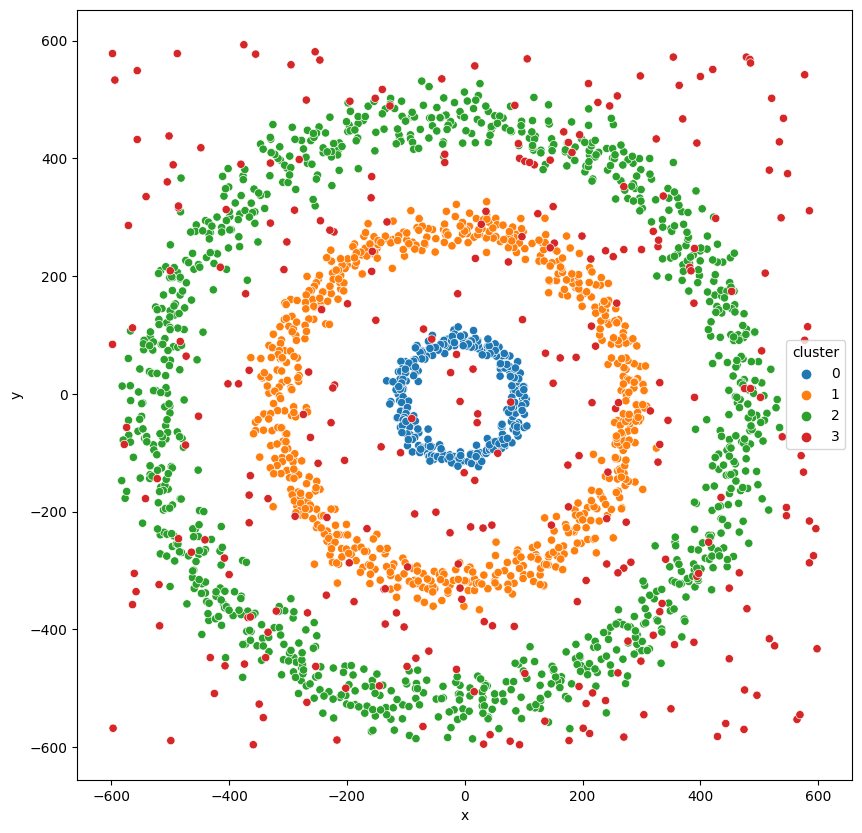

In [ ]:
# Convertimos a DF
def arrray_to_df(arr, i):
  df = pd.DataFrame(arr)
  df['cluster'] = str(i)
  return df

data = [arrray_to_df(arr, i) for i, arr in enumerate([small_circle, medium_circle, big_circle, noise])]

data = pd.concat(data)
data.columns = ['x', 'y', 'cluster']


plt.rcParams['figure.figsize'] = [10,10]
sns.scatterplot(
    data = data,
    x = 'x',
    y = 'y',
    hue = 'cluster'
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

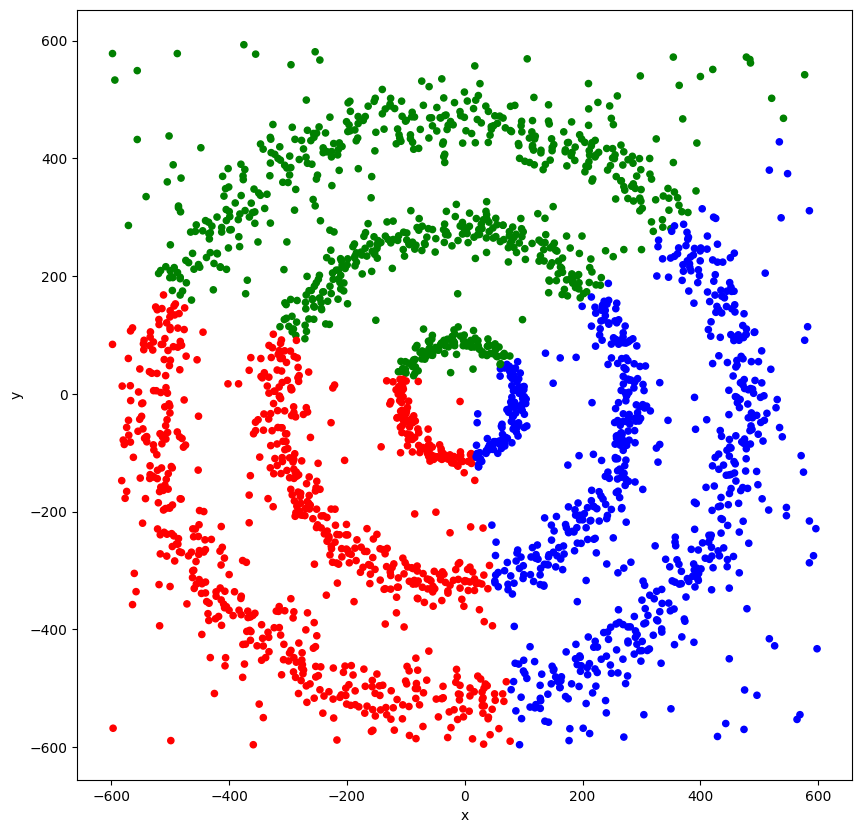

In [ ]:
data_norm = normalize(data)

preds = KMeans(n_clusters = 3, random_state =123).fit_predict(data_norm)

cols = {
  0: 'r',
  1: 'g',
  2: 'b'
}

data['kmeans_pred'] = [cols.get(pred) for pred in preds]
data.plot.scatter('x', 'y', c='kmeans_pred')

In [ ]:
preds

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [ ]:
data

,x,y,cluster,kmeans_pred
0,94.692420,-19.815515,0,b
1,104.239353,-8.938954,0,b
2,82.596786,5.150681,0,b
3,98.245170,-7.997451,0,b
4,89.609153,-21.974003,0,b
...,...,...,...,...
295,14.000000,42.000000,3,g
296,-334.000000,-405.000000,3,r
297,85.000000,490.000000,3,g
298,277.000000,-420.000000,3,b


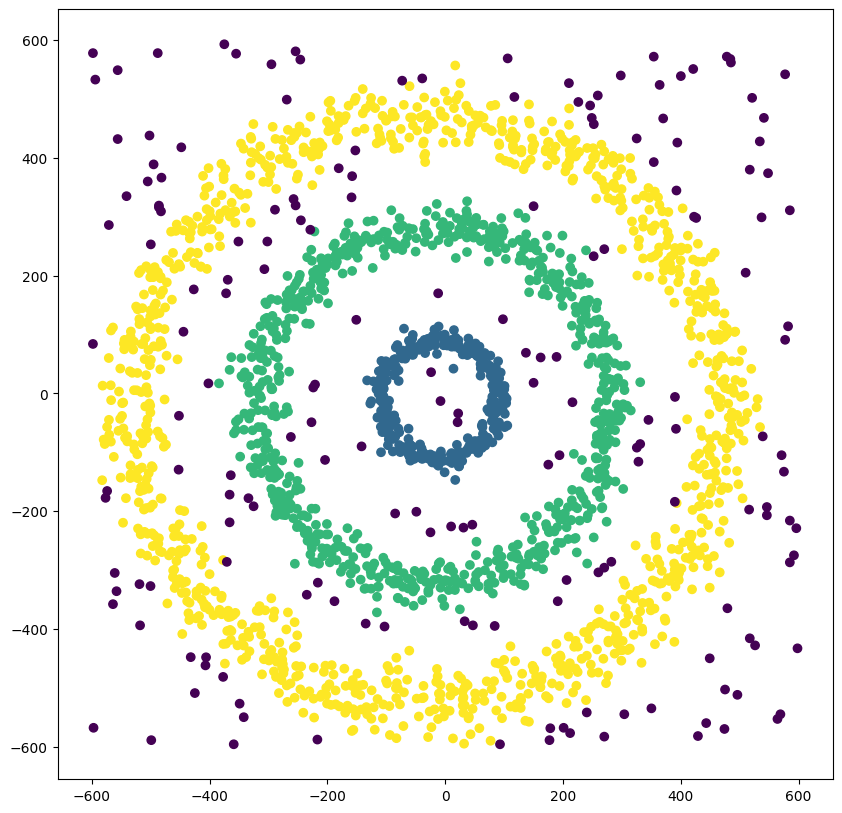

In [ ]:
data['dbscan'] = DBSCAN(eps=32, min_samples=5).fit_predict(data[['x', 'y']])

plt.scatter(
    data['x'],
    data['y'],
    c = data['dbscan']
)

How to choose parameters in DBSCAN
To choose the parameter epsilon, that is, the maximum distance at which another observation must be to be considered to meet the criterion of “being close”, we must know how close or far the variables are from each other.

Usually there will be a few variables that will be very close to each other, and as the distance increases, the number of variables close to each other will increase. That graph is the one that will help us to choose the optimal value of epsilon.

To obtain the distance graph we will use Sklearn’s Nearest Neighbors model, since this function returns the information on the distance to our nearest neighbor.

Text(0, 0.5, 'Distance')

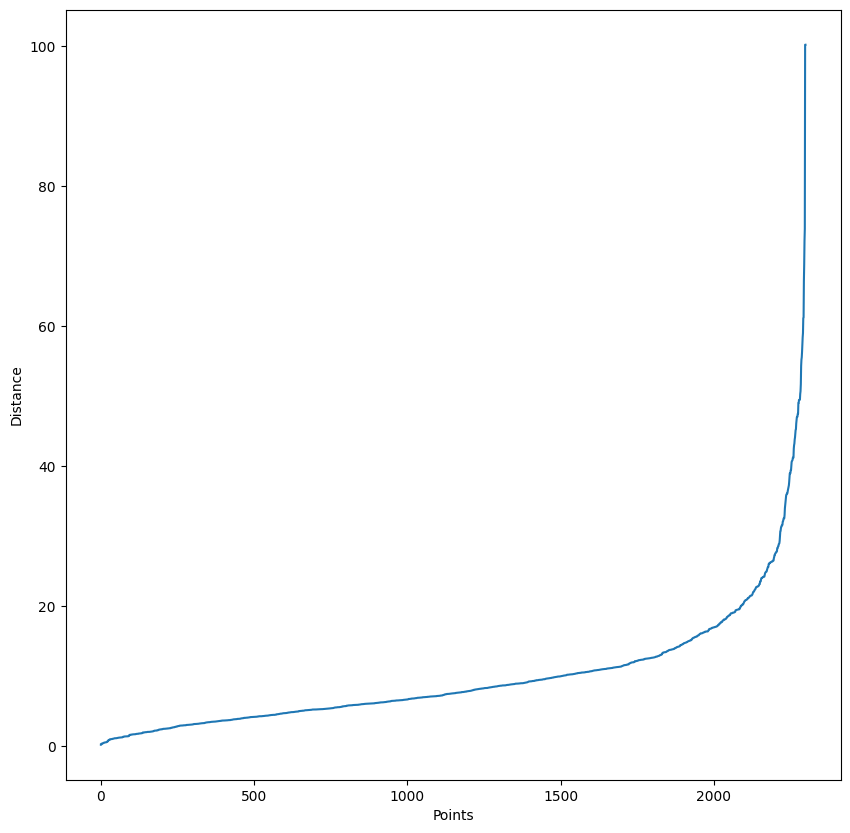

In [ ]:
k = 2
data_nn = data.copy()[['x', 'y']]

# Calculate NN
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Get distances
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)

plt.xlabel("Points")
plt.ylabel("Distance")

In [ ]:
min_samples = range(3,10)
eps = np.arange(15,35, 1) # returns array of ranging from 0.05 to 0.13 with step of 0.01

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(data_nn).labels_
        score = silhouette_score(data_nn, labels)
        output.append((ms, ep, score))

In [ ]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.09177963150633797
min_samples: 9
eps: 32


In [ ]:
# Counter for counting the number of data points in each clusters

from collections import Counter

In [ ]:
labels = DBSCAN(min_samples=min_samples, eps = 32).fit(data_nn).labels_
clusters = len(Counter(labels))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(labels)[-1]}")
print(f"Silhouette_score: {silhouette_score(data_nn, labels)}")

Number of clusters: 7
Number of outliers: 245
Silhouette_score: 0.09177963150633797


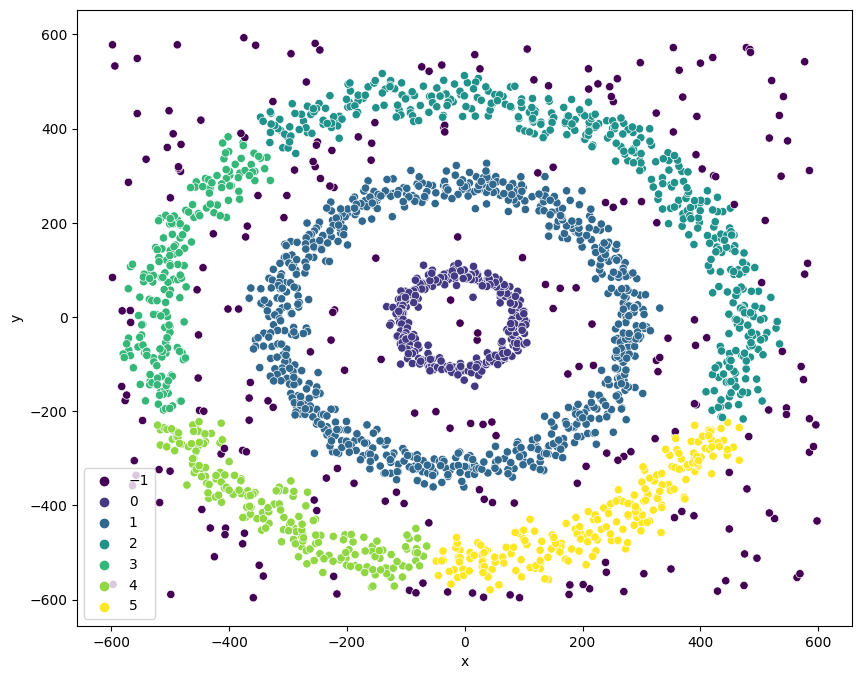

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=data_nn['x'], y=data_nn['y'], hue=labels, palette='viridis');

In [ ]:
class dbscan:

  def __init__(self, epsilon = None, min_samples = None, distance = 'euclidean', normalize = False):
    self.epsilon = epsilon
    self.min_samples = min_samples
    self.distance = distance
    self.normalize = normalize

  def find_distance(self, x, type = 'euclidean'):
    """
    Finds distance between numpy arrays.
    """
    return distance.squareform(distance.pdist(x, type))

  def normalization(self, x):
    return (x-np.min(x))/(np.max(x) - np.min(x))

  def find_neighbors(self, x):
    return np.where(x <= self.epsilon)[0]

  def expand_cluster(self, neighbors, x, cluster, labels):

    # Iterate over each neighbor
    for neighbor in neighbors:

      # Check that is not assigned
      if labels[neighbor] == 0:

        # Find neighbors
        neighbor_neighbors = self.find_neighbors(x[neighbor])

        # Check if is core
        if len(neighbor_neighbors) >= self.min_samples:
            labels[neighbor] = cluster

            # For each neighbor in neighbors, expand cluster
            labels = self.expand_cluster(neighbor_neighbors, x, cluster, labels)

    return labels

  def fit(self, x):
    """
    Given a reference point and comparison points and a distance function, returns the index of the neighbors.
    """
    # Do normalization
    if self.normalize:
      x = self.normalization(x)

    # Find distance
    dist_matrix = self.find_distance(x, self.distance)

    # Initialize cluster
    cluster = 1
    n_obs = x.shape[0]
    labels = np.zeros(n_obs)

    for i in range(n_obs):

      # If value not assigned
      if labels[i] == 0:

        # Find neighbors
        neighbors = self.find_neighbors(dist_matrix[i])

        # Check if neighbors > min_samples (self included as neighbor)
        if len(neighbors) > self.min_samples:

          # If observation is not assigned --> Assign to cluster
          if labels[i] == 0:
            labels[i] = cluster

          # Expand cluster on neighbors
          labels = self.expand_cluster(neighbors, dist_matrix, cluster, labels)

          # Go to next cluster
          cluster = cluster + 1

    return labels

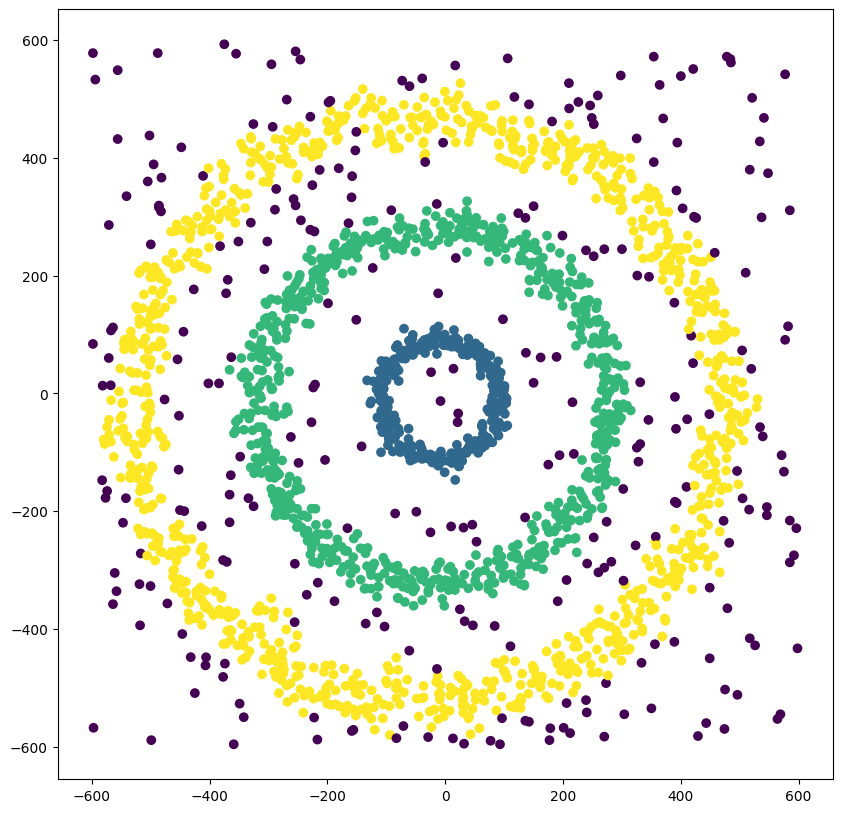

In [ ]:
data['dbscan_custom'] = dbscan(epsilon=32, min_samples=5).fit(data[['x', 'y']].to_numpy())

plt.scatter(
    data['x'],
    data['y'],
    c = data['dbscan_custom']
)